# f-scLVM

In this notebook we illustrate how f-scLVM can be used to identify biological processes driving variability between cells. 

First, we load some modules and set some directories

In [1]:
import sys
sys.path.append('./../..')
import os
import scipy as SP
import cPickle as pickle
import core.utils as utils
import core.fscLVM as fscLVM

import h5py
%pylab inline

data_dir = '../../../data/'
out_base = './../results/'



Populating the interactive namespace from numpy and matplotlib


f-scLVM expects a hdf file containing the normalised, log transformed gene expression data as well as a set of annotations.

In [2]:
dFile = 'Buettneretal.hdf5'
#name of annotation
anno = 'MSigDBdemo'

#number of hidden (unannotated variables)
nHidden = 3
#indices of known covariates
idx_known = []

idxCol=[0,1]


Next we need to load the relevant data from the hdf5 file. minGenes is the minimum number of genes in a pathway.

In [3]:
data = utils.load_data(dFile, annotation='MSigDB', minGenes=15, nHidden=nHidden, doFast=True)


Next, we initialise the model and iterate.


In [4]:
Y = data['Y']

#use pre-training to determine initial update order 
init_factors = {}
init_factors['iLatent'] = SP.where(data['terms']=='hidden')[0]
Ilabel = utils.getIlabel('preTrain',Y, data['terms'], data['pi'],init_factors) 

#re-order terms
print "Initial order", data['terms'][Ilabel]
terms = data['terms'][Ilabel]
pi = data['pi'][:,Ilabel]


#initialise model
init={'init_data':fscLVM.CGauss(Y),'Pi':pi,'init_factors':init_factors}
priors = {'Eps': {'priors':[1E-3,1E-3]}}
FA = fscLVM.CSparseFA(components=pi.shape[1], priors=priors,verbose=True)            
FA.init(**init) 

#iterate
FA.iterate()


Initial order ['hidden' 'hidden' 'hidden' 'G2M_CHECKPOINT' 'P53_PATHWAY'
 'UNFOLDED_PROTEIN_RESPONSE' 'EPITHELIAL_MESENCHYMAL_TRANSITION'
 'PROTEIN_SECRETION' 'XENOBIOTIC_METABOLISM' 'MITOTIC_SPINDLE'
 'UV_RESPONSE_UP' 'TNFA_SIGNALING_VIA_NFKB' 'ADIPOGENESIS'
 'MTORC1_SIGNALING' 'MYOGENESIS' 'KRAS_SIGNALING_UP'
 'OXIDATIVE_PHOSPHORYLATION' 'DNA_REPAIR' 'MYC_TARGETS_V2' 'APICAL_SURFACE'
 'TGF_BETA_SIGNALING' 'CHOLESTEROL_HOMEOSTASIS' 'PEROXISOME' 'COAGULATION'
 'MYC_TARGETS_V1' 'IL2_STAT5_SIGNALING' 'IL6_JAK_STAT3_SIGNALING'
 'ANDROGEN_RESPONSE' 'PI3K_AKT_MTOR_SIGNALING' 'BILE_ACID_METABOLISM'
 'SPERMATOGENESIS' 'FATTY_ACID_METABOLISM' 'INTERFERON_ALPHA_RESPONSE'
 'E2F_TARGETS' 'UV_RESPONSE_DN' 'APOPTOSIS' 'COMPLEMENT'
 'ALLOGRAFT_REJECTION' 'HEME_METABOLISM' 'INFLAMMATORY_RESPONSE'
 'GLYCOLYSIS' 'APICAL_JUNCTION' 'KRAS_SIGNALING_DN' 'HYPOXIA'
 'ESTROGEN_RESPONSE_LATE' 'INTERFERON_GAMMA_RESPONSE'
 'ESTROGEN_RESPONSE_EARLY']
iterate...
iter 0
iter 100
iter 200
iter 300
iter 400
iter 500


0.56195819697664851


We then plot results. First, we show the relevance of the terms; then we plot the 2 most important factors, in this case G2M Checkpoint and P53 Pathway. 

./../../core/utils.py:102: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  assert terms!=None


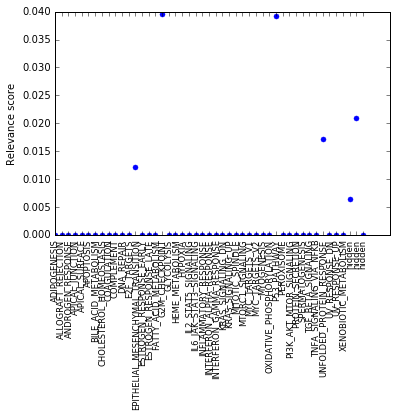

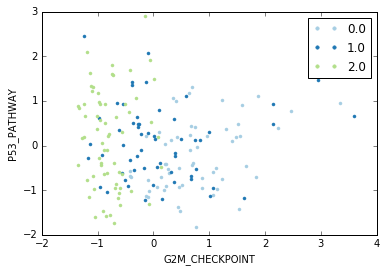

In [5]:
#scatter plot of two most important factors
utils.plotTerms(FA, terms=terms)

dataFile = h5py.File(os.path.join(data_dir, dFile), 'r')
utils.plotFactors(0,1,FA,lab = dataFile['Known'][:][0,:]+2*dataFile['Known'][:][1,:], terms=terms, isCont=False)


In [20]:
#specify out_file
#utils.saveFA(FA)